In [2]:
import xarray as xr

In [52]:
# Buka file .nc
nc_file = '/Users/mb2/learn-python/ml-sattelite/data/raw/H09_B13_Indonesia_202504010600.nc'
ds = xr.open_dataset(nc_file)

In [53]:
print(ds)

<xarray.Dataset> Size: 383kB
Dimensions:     (latitude: 271, longitude: 351)
Coordinates:
  * latitude    (latitude) float32 1kB -6.1 -6.12 -6.14 ... -11.46 -11.48 -11.5
  * longitude   (longitude) float32 1kB 114.0 114.1 114.1 ... 121.0 121.0 121.0
Data variables:
    tbb         (latitude, longitude) float32 380kB ...
    start_time  datetime64[ns] 8B ...
    end_time    datetime64[ns] 8B ...
Attributes:
    title:        Himawari-9 band-13 TBB
    institution:  MSC/JMA
    source:       Himawari-9 satellite observation
    history:      at 06:03:09 04/01/2025: file created. H09_B13_Indonesia_202...
    Conventions:  CF-1.4


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd

In [55]:
# Ambil data brightness temperature
tbb = ds['tbb'] - 273.15  # convert to Celsius

# Koordinat original
lon = ds['longitude'].values
lat = ds['latitude'].values

# Grid baru 3x lipat supaya smooth (interpolasi)
lon_new = np.linspace(lon.min(), lon.max(), lon.size * 3)
lat_new = np.linspace(lat.min(), lat.max(), lat.size * 3)
lon_grid, lat_grid = np.meshgrid(lon, lat)
lon_new_grid, lat_new_grid = np.meshgrid(lon_new, lat_new)

In [56]:
# Flatten untuk interpolasi
points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
values = tbb.values.ravel()

# Interpolasi cubic agar smooth
tbb_smooth = griddata(points, values, (lon_new_grid, lat_new_grid), method='cubic')

# Warna dan bounds
bounds = [-100, -80, -75, -69, -62, -56, -48, -41, -34, -28, -21, -13, -7, 0, 8, 14, 21, 60]
colors = [
    '#800000', '#FF0000', '#FF5A00', '#FFB400', '#DBFF00', '#42FF00', '#1AFF00', '#00FF5A',
    '#00FFCB', '#00D1FF', '#0090FF', '#0047FF', '#0003FF', '#02008E', '#06005E', '#0A0031', '#0A0020'
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))

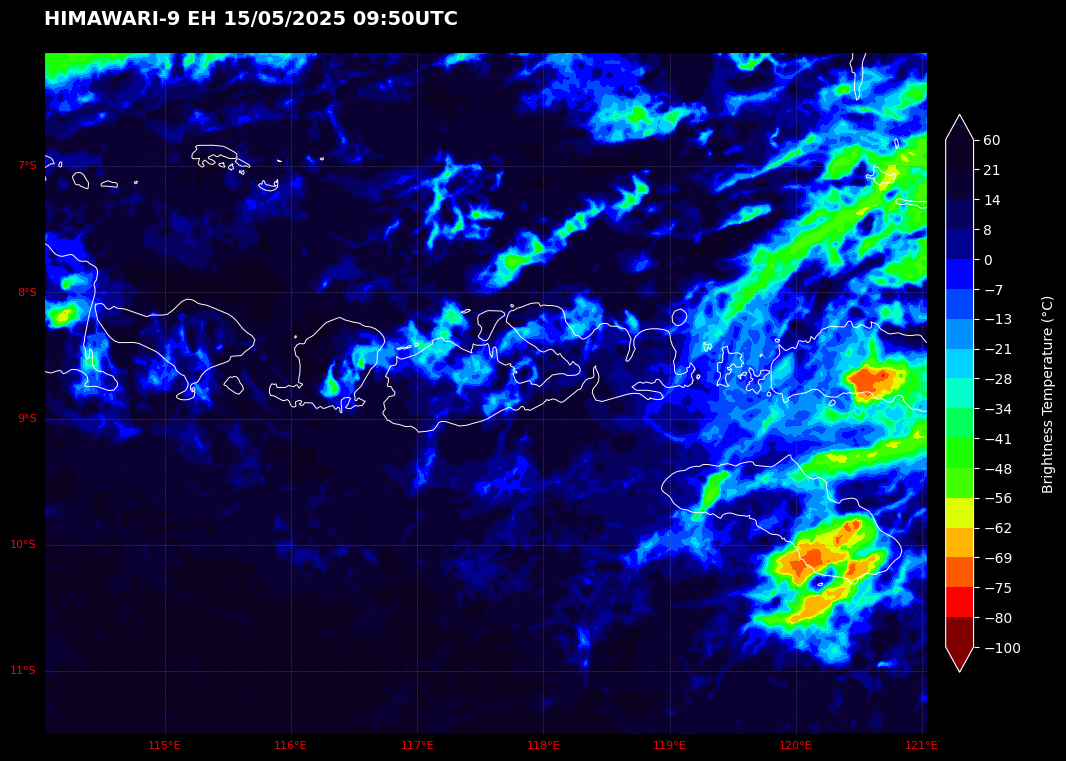

In [57]:
# Membuat figure
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data kontur dengan smooth color
cf = ax.contourf(lon_new, lat_new, tbb_smooth,
                 levels=bounds, cmap=cmap, norm=norm, extend='both',
                 transform=ccrs.PlateCarree())

# Tambah fitur Pulau dengan garis putih
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='white', facecolor='none', linewidth=0.7)
ax.add_feature(land)

# Tambah batas negara dengan garis putih tipis
ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='white', linewidth=0.5)

# Set wilayah peta
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Gridlines dengan label
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray',
                  alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True
gl.xlabel_style = {'color': 'red', 'fontsize': 8}
gl.ylabel_style = {'color': 'red', 'fontsize': 8}

# Colorbar dengan background hitam transparan dan font putih
cbar = plt.colorbar(cf, ax=ax, fraction=0.03, pad=0.02,
                    ticks=bounds, boundaries=bounds)
cbar.set_label('Brightness Temperature (°C)', color='white', fontsize=10, labelpad=15)

# Set warna font ticks dan label colorbar jadi putih
cbar.ax.yaxis.label.set_color('white')
cbar.ax.tick_params(colors='white')

# Buat background colorbar hitam dengan transparansi
cbar.outline.set_edgecolor('white')  # garis pinggir putih di colorbar
cbar.ax.set_facecolor((0, 0, 0, 0.7))  # background hitam transparan

# Buat background plot figure hitam
fig.patch.set_facecolor('black')

# Judul warna putih dengan background hitam transparan dan padding
plt.title('HIMAWARI-9 EH 15/05/2025 09:50UTC', fontsize=14, fontweight='bold', color='white',
          loc='left', pad=20, 
          bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))

plt.show()
ds.close()